In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/newdatast/Retail_datasett.csv
/kaggle/input/retail-info/Retail_dataset.xlsx
/kaggle/input/tryingagain/Retail_datasett.csv


# Checking the dataset

In [2]:
df = pd.read_csv('/kaggle/input/tryingagain/Retail_datasett.csv')
print(df.head())

       Date Store ID Product ID    Category Region  Inventory Level  \
0  1/1/2022     S001      P0001      fruits  North              231   
1  1/1/2022     S001      P0002  Toothpaste  South              204   
2  1/1/2022     S001      P0003  Toothpaste   West              102   
3  1/1/2022     S001      P0004  Toothpaste  North              469   
4  1/1/2022     S001      P0005     Battery   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164            62.18  32.72        10   
4          14            135             9.26  73.64         0   

  Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
0             Rainy                  0               29.69      Autumn  
1             Sunny           

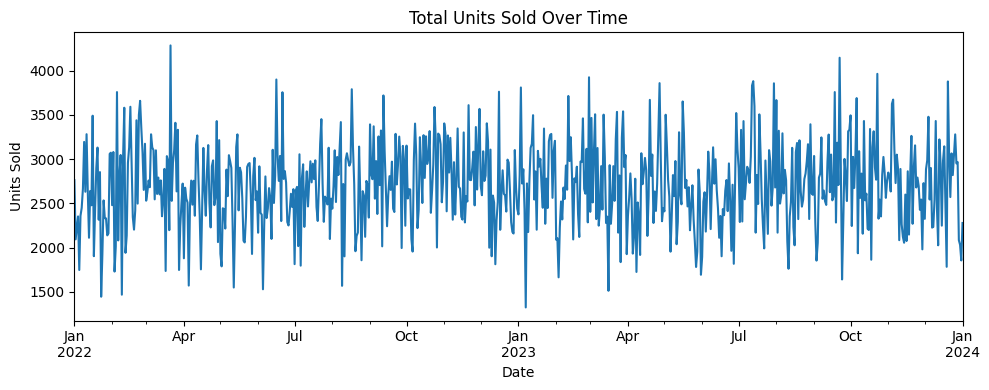

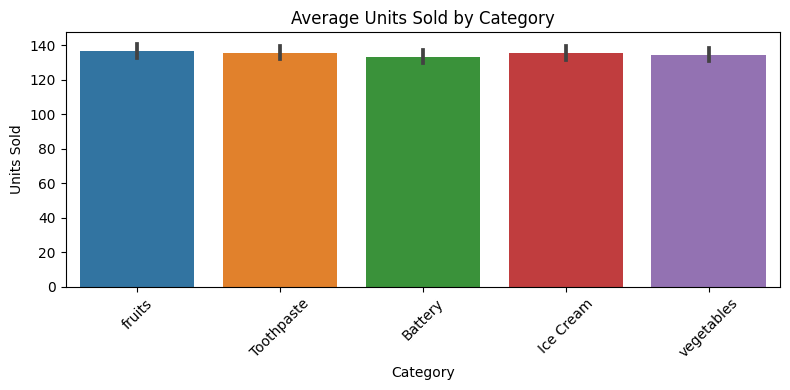

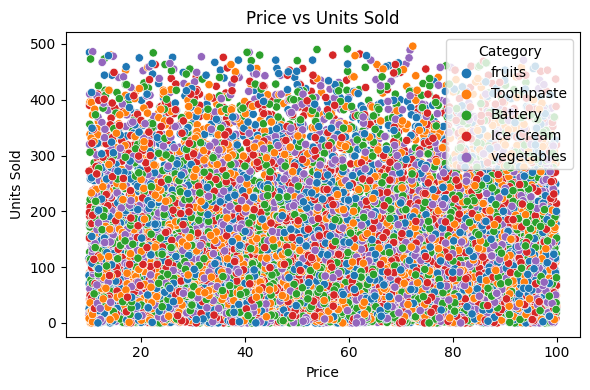

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv("/kaggle/input/tryingagain/Retail_datasett.csv")
df['Date'] = pd.to_datetime(df['Date'])  # Ensure date column is datetime
sales_over_time = df.groupby('Date')['Units Sold'].sum()

plt.figure(figsize=(10, 4))
sales_over_time.plot()
plt.title('Total Units Sold Over Time')
plt.ylabel('Units Sold')
plt.xlabel('Date')
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 4))
sns.barplot(data=df, x='Category', y='Units Sold', estimator='mean')
plt.title('Average Units Sold by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='Price', y='Units Sold', hue='Category')
plt.title('Price vs Units Sold')
plt.tight_layout()
plt.show()


# NOW WORKING ON TRAINING THE MODEL

In [4]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


18:48:59 - cmdstanpy - INFO - Chain [1] start processing
18:48:59 - cmdstanpy - INFO - Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
0   2022-01-02  126.737687  116.972552  136.645822
1   2022-01-09  131.389247  121.324565  141.225763
2   2022-01-16  135.887376  126.369333  146.277083
3   2022-01-23  135.645171  124.699103  145.245061
4   2022-01-30  132.596564  122.818497  142.214370
..         ...         ...         ...         ...
131 2024-07-07  139.515673  129.582966  149.995777
132 2024-07-14  144.226156  133.923991  154.386817
133 2024-07-21  146.936260  136.677594  156.298893
134 2024-07-28  145.940242  135.612583  156.018471
135 2024-08-04  143.058999  133.967908  153.068944

[136 rows x 4 columns]


  0%|          | 0/2 [00:00<?, ?it/s]

18:48:59 - cmdstanpy - INFO - Chain [1] start processing
18:49:00 - cmdstanpy - INFO - Chain [1] done processing
18:49:00 - cmdstanpy - INFO - Chain [1] start processing
18:49:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon         mse       rmse        mae      mape     mdape     smape  \
0  6 days    2.712118   1.646851   1.404172  0.010214  0.010214  0.010286   
1 11 days    2.996493   1.731038   1.597178  0.011503  0.011503  0.011561   
2 13 days   24.285181   4.928000   3.918330  0.027092  0.027092  0.026527   
3 18 days   38.881857   6.235532   6.194722  0.042509  0.042509  0.042310   
4 20 days  158.278737  12.580888  11.204398  0.076384  0.076384  0.073592   

   coverage  
0       1.0  
1       1.0  
2       1.0  
3       1.0  
4       0.5  


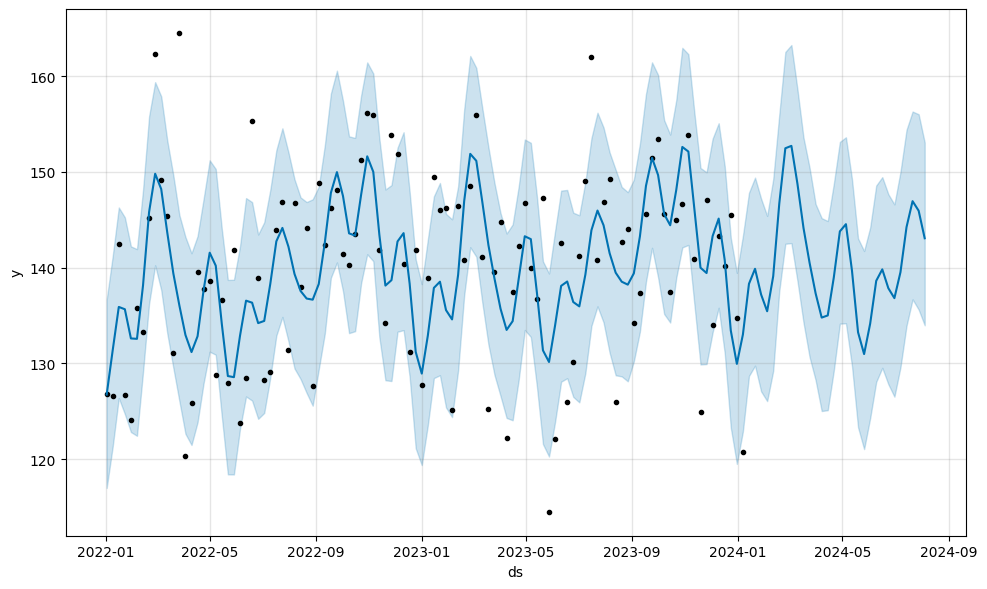

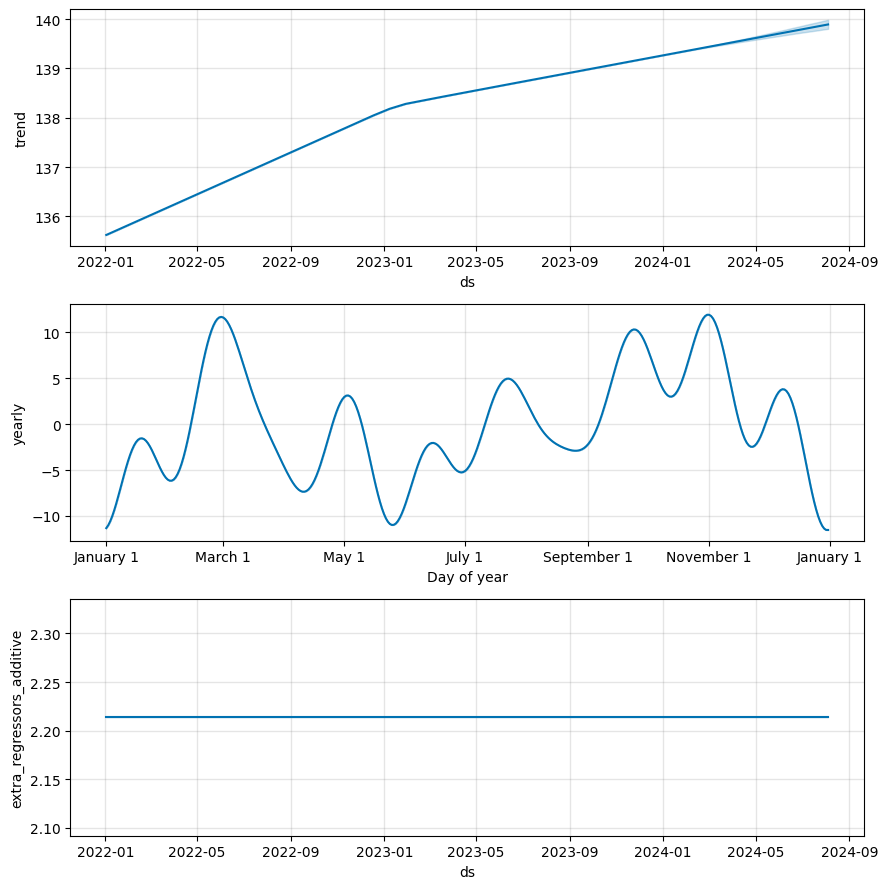

In [6]:
import pandas as pd
from prophet import Prophet
model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.1)

# Load the dataset
df = pd.read_csv('/kaggle/input/tryingagain/Retail_datasett.csv')

# Filter data for a specific store
store_id = 'S001'  # Replace with the desired store ID
df_filtered = df[df['Store ID'] == store_id]

# Rename columns for Prophet
df_filtered = df_filtered.rename(columns={'Date': 'ds', 'Demand Forecast': 'y'})

# Convert 'ds' to datetime
df_filtered['ds'] = pd.to_datetime(df_filtered['ds'])

# Select numeric columns for aggregation
numeric_cols = ['y', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing']
df_numeric = df_filtered[['ds'] + numeric_cols]

# Aggregate numeric data to weekly level
df_numeric.set_index('ds', inplace=True)
df_weekly_numeric = df_numeric.resample('W').mean().reset_index()

# Handle 'Weather Condition' separately by taking the mode
df_filtered.set_index('ds', inplace=True)
df_weekly_weather = df_filtered['Weather Condition'].resample('W').agg(lambda x: x.mode()[0]).reset_index()

# Merge the numeric and weather data
df_weekly = pd.merge(df_weekly_numeric, df_weekly_weather, on='ds')

# Convert categorical variables to dummy variables
df_weekly = pd.get_dummies(df_weekly, columns=['Weather Condition'])

# Initialize the Prophet model
model = Prophet()

# Add regressors
model.add_regressor('Price')
model.add_regressor('Discount')
model.add_regressor('Holiday/Promotion')
model.add_regressor('Competitor Pricing')

# Add dummy variables for weather conditions
for column in df_weekly.columns:
    if 'Weather Condition_' in column:
        model.add_regressor(column)

# Fit the model
model.fit(df_weekly)

# Create a DataFrame for future dates
future = model.make_future_dataframe(periods=30, freq='W')  # Weekly frequency

# Add regressors to the future DataFrame
future['Price'] = df_weekly['Price'].mean()  # Replace with actual future values if available
future['Discount'] = df_weekly['Discount'].mean()
future['Holiday/Promotion'] = df_weekly['Holiday/Promotion'].mean()
future['Competitor Pricing'] = df_weekly['Competitor Pricing'].mean()

# Add dummy variables for weather conditions
for column in df_weekly.columns:
    if 'Weather Condition_' in column:
        future[column] = df_weekly[column].mean()  # Replace with actual future values if available

# Make predictions
forecast = model.predict(future)
# Display the forecasted data
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


# Visualize the forecast
fig = model.plot(forecast)

# Plot components to see trend and seasonality separately
fig2 = model.plot_components(forecast)
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='90 days')

# Calculate performance metrics
df_p = performance_metrics(df_cv)

# Print the performance metrics
print(df_p.head())

# CHECKING FOR OUTLIERS TO IMPROVE THE MODEL PERFORMANCE

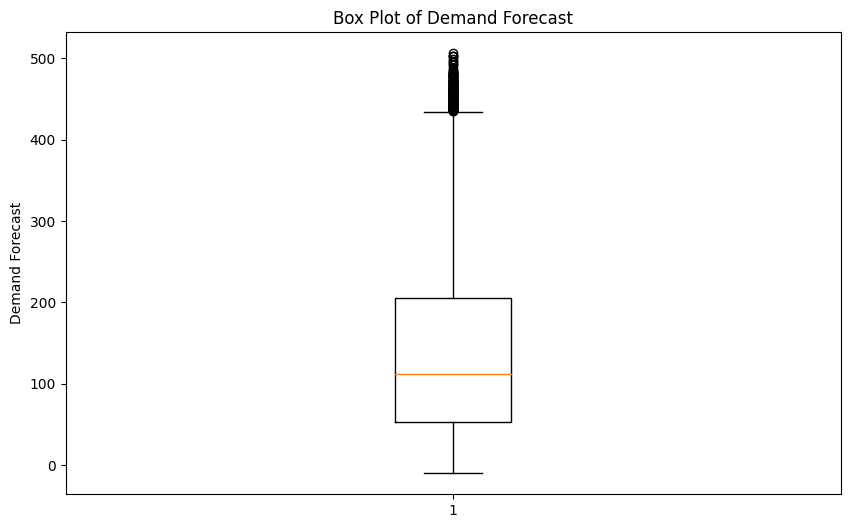

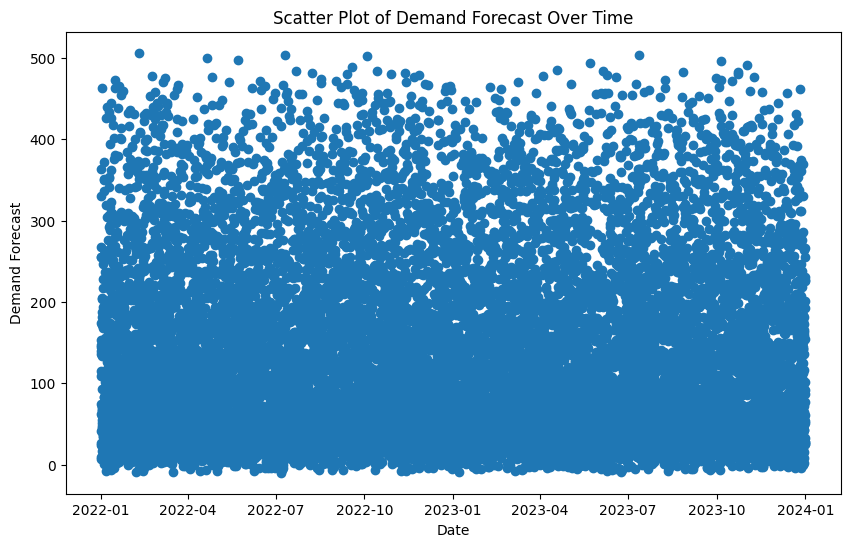

Outliers based on Z-score:
              ds Store ID Product ID    Category Region  Inventory Level  \
312   2022-01-16     S001      P0013   Ice Cream  South              482   
805   2022-02-10     S001      P0006  vegetables   East              491   
1077  2022-02-23     S001      P0018  vegetables  North              497   
1291  2022-03-06     S001      P0012      fruits  South              490   
1326  2022-03-08     S001      P0007      fruits   West              480   
2216  2022-04-21     S001      P0017     Battery   East              497   
2308  2022-04-26     S001      P0009      fruits  North              476   
2665  2022-05-14     S001      P0006     Battery   West              493   
2853  2022-05-23     S001      P0014      fruits  North              492   
3302  2022-06-15     S001      P0003  Toothpaste   West              466   
3831  2022-07-11     S001      P0012  Toothpaste   West              500   
4059  2022-07-22     S001      P0020     Battery  North      

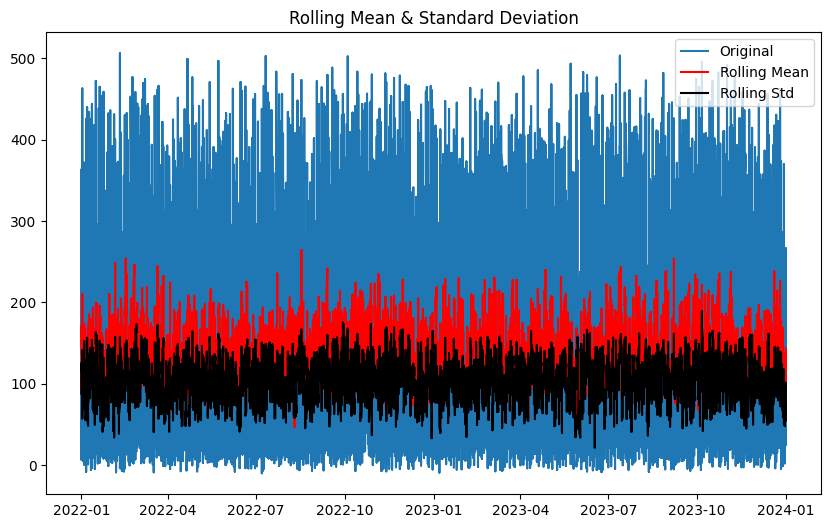

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Load the dataset
df = pd.read_csv('/kaggle/input/tryingagain/Retail_datasett.csv')

# Filter data for a specific store
store_id = 'S001'  # Replace with the desired store ID
df_filtered = df[df['Store ID'] == store_id]

# Rename columns for Prophet
df_filtered = df_filtered.rename(columns={'Date': 'ds', 'Demand Forecast': 'y'})

# Convert 'ds' to datetime
df_filtered['ds'] = pd.to_datetime(df_filtered['ds'])

# Visual Inspection: Box Plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_filtered['y'])
plt.title('Box Plot of Demand Forecast')
plt.ylabel('Demand Forecast')
plt.show()

# Visual Inspection: Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['ds'], df_filtered['y'])
plt.title('Scatter Plot of Demand Forecast Over Time')
plt.xlabel('Date')
plt.ylabel('Demand Forecast')
plt.show()

# Statistical Method: Z-Score
df_filtered['z_score'] = zscore(df_filtered['y'])

# Identify outliers based on Z-score
outliers_z = df_filtered[(df_filtered['z_score'] > 3) | (df_filtered['z_score'] < -3)]
print("Outliers based on Z-score:")
print(outliers_z)

# Statistical Method: IQR
Q1 = df_filtered['y'].quantile(0.25)
Q3 = df_filtered['y'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers based on IQR
outliers_iqr = df_filtered[(df_filtered['y'] < (Q1 - 1.5 * IQR)) | (df_filtered['y'] > (Q3 + 1.5 * IQR))]
print("Outliers based on IQR:")
print(outliers_iqr)

# Time Series Specific Method: Rolling Statistics
rolling_mean = df_filtered['y'].rolling(window=12).mean()
rolling_std = df_filtered['y'].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['ds'], df_filtered['y'], label='Original')
plt.plot(df_filtered['ds'], rolling_mean, color='red', label='Rolling Mean')
plt.plot(df_filtered['ds'], rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

# REMOVING OUTLIERS

In [8]:
import pandas as pd
from scipy.stats import zscore

# assume df_filtered already has your store’s data with columns ['ds','y']

# 1) Compute Z‑scores
df_filtered = df_filtered.copy()
df_filtered['z_score'] = zscore(df_filtered['y'])

# 2) Compute IQR bounds
Q1 = df_filtered['y'].quantile(0.25)
Q3 = df_filtered['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3) Build masks for outliers
mask_out_z    = df_filtered['z_score'].abs() > 3
mask_out_iqr  = (df_filtered['y'] < lower_bound) | (df_filtered['y'] > upper_bound)

# 4) Combine masks: mark as outlier if either test is True
mask_outlier = mask_out_z | mask_out_iqr

# 5) Keep only the non‐outliers
df_clean = df_filtered.loc[~mask_outlier].reset_index(drop=True)

print(f"Original rows: {len(df_filtered)}, after removing outliers: {len(df_clean)}")

# (Optional) drop the helper column
df_clean = df_clean.drop(columns=['z_score'])

Original rows: 14620, after removing outliers: 14463


18:49:15 - cmdstanpy - INFO - Chain [1] start processing
18:49:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

18:49:15 - cmdstanpy - INFO - Chain [1] start processing
18:49:15 - cmdstanpy - INFO - Chain [1] done processing
18:49:15 - cmdstanpy - INFO - Chain [1] start processing
18:49:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon         mse       rmse        mae      mape     mdape     smape  \
0  6 days    2.712118   1.646851   1.404172  0.010214  0.010214  0.010286   
1 11 days    2.996493   1.731038   1.597178  0.011503  0.011503  0.011561   
2 13 days   24.285181   4.928000   3.918330  0.027092  0.027092  0.026527   
3 18 days   38.881857   6.235532   6.194722  0.042509  0.042509  0.042310   
4 20 days  158.278737  12.580888  11.204398  0.076384  0.076384  0.073592   

   coverage  
0       1.0  
1       1.0  
2       1.0  
3       1.0  
4       0.5  


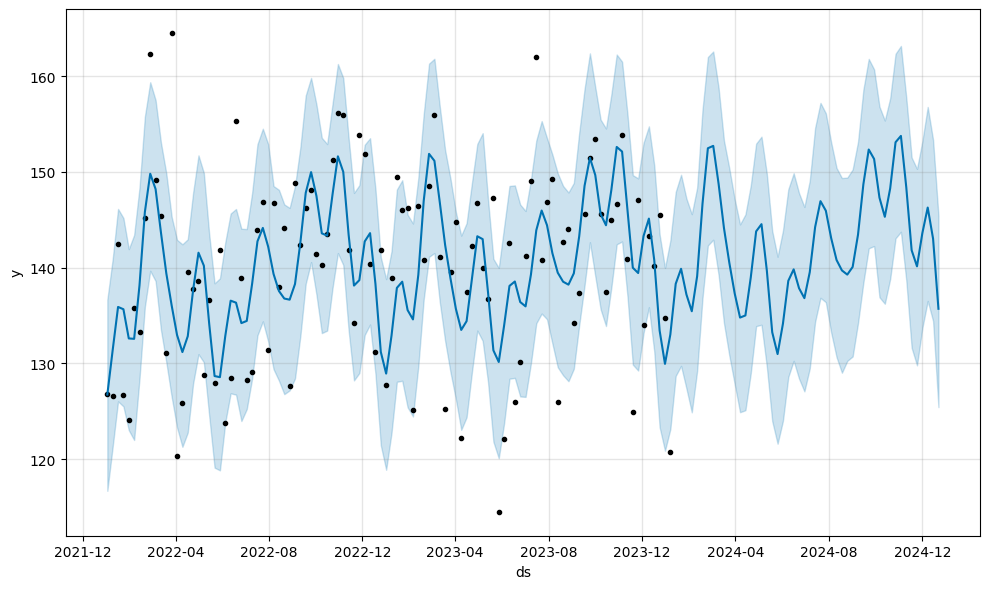

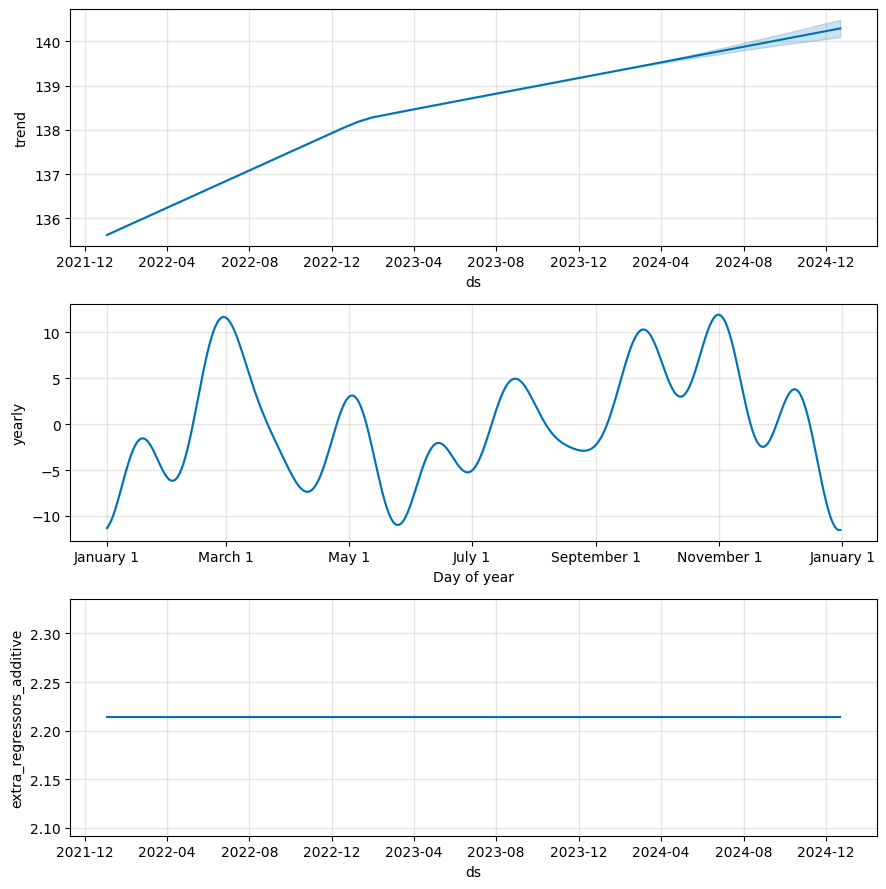

In [9]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Load the dataset
df = pd.read_csv('/kaggle/input/tryingagain/Retail_datasett.csv')

# Filter data for a specific store
store_id = 'S001'  # Replace with the desired store ID
df_filtered = df[df['Store ID'] == store_id]

# Rename columns for Prophet
df_filtered = df_filtered.rename(columns={'Date': 'ds', 'Demand Forecast': 'y'})

# Convert 'ds' to datetime
df_filtered['ds'] = pd.to_datetime(df_filtered['ds'])

# Select numeric columns for aggregation
numeric_cols = ['y', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing']
df_numeric = df_filtered[['ds'] + numeric_cols]

# Aggregate numeric data to weekly level
df_numeric.set_index('ds', inplace=True)
df_weekly_numeric = df_numeric.resample('W').mean().reset_index()

# Handle 'Weather Condition' separately by taking the mode
df_filtered.set_index('ds', inplace=True)
df_weekly_weather = df_filtered['Weather Condition'].resample('W').agg(lambda x: x.mode()[0]).reset_index()

# Merge the numeric and weather data
df_weekly = pd.merge(df_weekly_numeric, df_weekly_weather, on='ds')

# Convert categorical variables to dummy variables
df_weekly = pd.get_dummies(df_weekly, columns=['Weather Condition'])

# Initialize the Prophet model
model = Prophet()

# Add regressors
model.add_regressor('Price')
model.add_regressor('Discount')
model.add_regressor('Holiday/Promotion')
model.add_regressor('Competitor Pricing')

# Add dummy variables for weather conditions
for column in df_weekly.columns:
    if 'Weather Condition_' in column:
        model.add_regressor(column)

# Fit the model
model.fit(df_weekly)

# Create a DataFrame for future dates
future = model.make_future_dataframe(periods=50, freq='W')  # Weekly frequency

# Add regressors to the future DataFrame
future['Price'] = df_weekly['Price'].mean()  # Replace with actual future values if available
future['Discount'] = df_weekly['Discount'].mean()
future['Holiday/Promotion'] = df_weekly['Holiday/Promotion'].mean()
future['Competitor Pricing'] = df_weekly['Competitor Pricing'].mean()

# Add dummy variables for weather conditions
for column in df_weekly.columns:
    if 'Weather Condition_' in column:
        future[column] = df_weekly[column].mean()  # Replace with actual future values if available

# Make predictions
forecast = model.predict(future)

# Save the forecasted data to a CSV file
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_output.csv', index=False)

# Visualize the forecast
fig = model.plot(forecast)

# Plot components to see trend and seasonality separately
fig2 = model.plot_components(forecast)

# Perform cross-validation
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='90 days')

# Calculate performance metrics
df_p = performance_metrics(df_cv)

# Print the performance metrics
print(df_p.head())


In [10]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Load the dataset
df = pd.read_csv('/kaggle/input/tryingagain/Retail_datasett.csv')

# Define the store ID and product ID range
store_id = 'S001'
product_ids = [f'P{str(i).zfill(4)}' for i in range(1, 21)]

# Prepare a DataFrame to store results
all_forecasts = pd.DataFrame()

# Loop through each product ID
for product_id in product_ids:
    # Filter data for the specific store and product
    df_filtered = df[(df['Store ID'] == store_id) & (df['Product ID'] == product_id)]

    # Rename columns for Prophet
    df_filtered = df_filtered.rename(columns={'Date': 'ds', 'Demand Forecast': 'y'})

    # Convert 'ds' to datetime
    df_filtered['ds'] = pd.to_datetime(df_filtered['ds'])

    # Select numeric columns for aggregation
    numeric_cols = ['y', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing']
    df_numeric = df_filtered[['ds'] + numeric_cols]

    # Aggregate numeric data to weekly level
    df_numeric.set_index('ds', inplace=True)
    df_weekly_numeric = df_numeric.resample('W').mean().reset_index()

    # Handle 'Weather Condition' and 'Seasonality' separately
    df_filtered.set_index('ds', inplace=True)
    df_weekly_weather = df_filtered['Weather Condition'].resample('W').agg(lambda x: x.mode()[0]).reset_index()
    df_weekly_seasonality = df_filtered['Seasonality'].resample('W').agg(lambda x: x.mode()[0]).reset_index()

    # Merge the numeric, weather, and seasonality data
    df_weekly = pd.merge(df_weekly_numeric, df_weekly_weather, on='ds')
    df_weekly = pd.merge(df_weekly, df_weekly_seasonality, on='ds')

    # Convert categorical variables to dummy variables
    df_weekly = pd.get_dummies(df_weekly, columns=['Weather Condition', 'Seasonality'])

    # Initialize the Prophet model
    model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.1)

    # Add regressors
    model.add_regressor('Price')
    model.add_regressor('Discount')
    model.add_regressor('Holiday/Promotion')
    model.add_regressor('Competitor Pricing')

    # Add dummy variables for weather conditions and seasonality
    for column in df_weekly.columns:
        if 'Weather Condition_' in column or 'Seasonality_' in column:
            model.add_regressor(column)

    # Fit the model
    model.fit(df_weekly)

    # Create a DataFrame for future dates
    future = model.make_future_dataframe(periods=50, freq='W')  # Weekly frequency

    # Add regressors to the future DataFrame
    future['Price'] = df_weekly['Price'].mean()  # Replace with actual future values if available
    future['Discount'] = df_weekly['Discount'].mean()
    future['Holiday/Promotion'] = df_weekly['Holiday/Promotion'].mean()
    future['Competitor Pricing'] = df_weekly['Competitor Pricing'].mean()

    # Add dummy variables for weather conditions and seasonality
    for column in df_weekly.columns:
        if 'Weather Condition_' in column or 'Seasonality_' in column:
            future[column] = df_weekly[column].mean()  # Replace with actual future values if available

    # Make predictions
    forecast = model.predict(future)

    # Calculate confidence as the inverse of the prediction interval width
    forecast['confidence'] = 1 / (forecast['yhat_upper'] - forecast['yhat_lower'])

    # Add product ID to the forecast
    forecast['Product ID'] = product_id

    # Append the forecast to the results DataFrame
    all_forecasts = pd.concat([all_forecasts, forecast[['Product ID', 'ds', 'yhat', 'yhat_lower', 'yhat_upper', 'confidence']]])

# Save the results to a CSV file
all_forecasts.to_csv('/kaggle/working/forecast_results.csv', index=False)

# Print the first few rows of the results
print(all_forecasts.head())

18:49:19 - cmdstanpy - INFO - Chain [1] start processing
18:49:19 - cmdstanpy - INFO - Chain [1] done processing
18:49:19 - cmdstanpy - INFO - Chain [1] start processing
18:49:19 - cmdstanpy - INFO - Chain [1] done processing
18:49:20 - cmdstanpy - INFO - Chain [1] start processing
18:49:20 - cmdstanpy - INFO - Chain [1] done processing
18:49:20 - cmdstanpy - INFO - Chain [1] start processing
18:49:20 - cmdstanpy - INFO - Chain [1] done processing
18:49:20 - cmdstanpy - INFO - Chain [1] start processing
18:49:20 - cmdstanpy - INFO - Chain [1] done processing
18:49:20 - cmdstanpy - INFO - Chain [1] start processing
18:49:20 - cmdstanpy - INFO - Chain [1] done processing
18:49:20 - cmdstanpy - INFO - Chain [1] start processing
18:49:20 - cmdstanpy - INFO - Chain [1] done processing
18:49:20 - cmdstanpy - INFO - Chain [1] start processing
18:49:20 - cmdstanpy - INFO - Chain [1] done processing
18:49:21 - cmdstanpy - INFO - Chain [1] start processing
18:49:21 - cmdstanpy - INFO - Chain [1]

  Product ID         ds        yhat  yhat_lower  yhat_upper  confidence
0      P0001 2022-01-02  108.611739   68.045624  145.840191    0.012854
1      P0001 2022-01-09  101.752497   58.370158  144.491191    0.011612
2      P0001 2022-01-16  112.228758   73.954529  155.153197    0.012315
3      P0001 2022-01-23  128.806069   88.501745  166.931439    0.012750
4      P0001 2022-01-30  139.739917  100.349173  184.501163    0.011883


# trying ARIMA

/tmp/ipykernel_33/2809780712.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])


ARIMA Model Evaluation:
MSE: 1414.41
RMSE: 37.61
MAE: 30.55


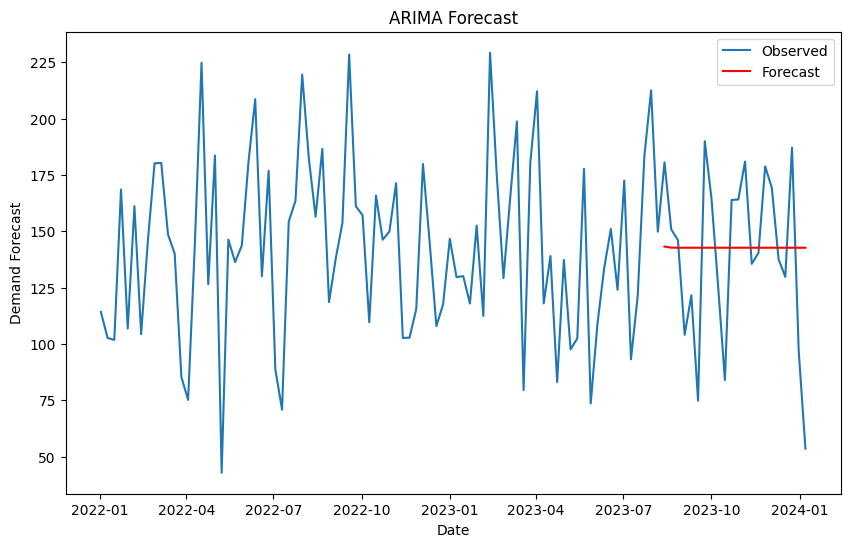

In [11]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load the dataset
df = pd.read_csv('/kaggle/input/tryingagain/Retail_datasett.csv')

# Filter data for a specific store and product
store_id = 'S001'
product_id = 'P0001'
df_filtered = df[(df['Store ID'] == store_id) & (df['Product ID'] == product_id)]

# Prepare the data
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])
df_filtered.set_index('Date', inplace=True)
y = df_filtered['Demand Forecast'].resample('W').mean()  # Resample to weekly data

# Split into train and test sets
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

# Fit ARIMA model
model = ARIMA(train, order=(1, 1, 1))  # Adjust the order as needed
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate the model
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)

print(f'ARIMA Model Evaluation:')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y, label='Observed')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Demand Forecast')
plt.legend()
plt.show()

# USING LSTM

2025-12-04 18:49:34.748459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764874174.945984      33 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764874175.005145      33 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
I0000 00:00:1764874186.345792      33 gpu_device.cc:2022] Created device /job:localhost/replica:0/t

Epoch 1/100


I0000 00:00:1764874190.989859     139 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 - 5s - 5s/step - loss: 0.2811 - val_loss: 0.3496
Epoch 2/100
1/1 - 0s - 44ms/step - loss: 0.2502 - val_loss: 0.3201
Epoch 3/100
1/1 - 0s - 42ms/step - loss: 0.2197 - val_loss: 0.2913
Epoch 4/100
1/1 - 0s - 41ms/step - loss: 0.2002 - val_loss: 0.2630
Epoch 5/100
1/1 - 0s - 41ms/step - loss: 0.1745 - val_loss: 0.2351
Epoch 6/100
1/1 - 0s - 41ms/step - loss: 0.1524 - val_loss: 0.2076
Epoch 7/100
1/1 - 0s - 41ms/step - loss: 0.1341 - val_loss: 0.1808
Epoch 8/100
1/1 - 0s - 41ms/step - loss: 0.1136 - val_loss: 0.1549
Epoch 9/100
1/1 - 0s - 41ms/step - loss: 0.0910 - val_loss: 0.1305
Epoch 10/100
1/1 - 0s - 41ms/step - loss: 0.0819 - val_loss: 0.1079
Epoch 11/100
1/1 - 0s - 41ms/step - loss: 0.0730 - val_loss: 0.0880
Epoch 12/100
1/1 - 0s - 41ms/step - loss: 0.0579 - val_loss: 0.0718
Epoch 13/100
1/1 - 0s - 41ms/step - loss: 0.0714 - val_loss: 0.0598
Epoch 14/100
1/1 - 0s - 44ms/step - loss: 0.0683 - val_loss: 0.0517
Epoch 15/100
1/1 - 0s - 41ms/step - loss: 0.0902 - val_loss: 0.0479
Epo

/tmp/ipykernel_33/2422608541.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, product_results])


1/1 - 3s - 3s/step - loss: 0.3701 - val_loss: 0.3418
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.3247 - val_loss: 0.3013
Epoch 3/100
1/1 - 0s - 39ms/step - loss: 0.2884 - val_loss: 0.2634
Epoch 4/100
1/1 - 0s - 39ms/step - loss: 0.2562 - val_loss: 0.2275
Epoch 5/100
1/1 - 0s - 40ms/step - loss: 0.2219 - val_loss: 0.1939
Epoch 6/100
1/1 - 0s - 40ms/step - loss: 0.1942 - val_loss: 0.1626
Epoch 7/100
1/1 - 0s - 40ms/step - loss: 0.1715 - val_loss: 0.1340
Epoch 8/100
1/1 - 0s - 42ms/step - loss: 0.1461 - val_loss: 0.1085
Epoch 9/100
1/1 - 0s - 41ms/step - loss: 0.1289 - val_loss: 0.0867
Epoch 10/100
1/1 - 0s - 41ms/step - loss: 0.1000 - val_loss: 0.0693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.3756 - val_loss: 0.1940
Epoch 2/100
1/1 - 0s - 42ms/step - loss: 0.3359 - val_loss: 0.1689
Epoch 3/100
1/1 - 0s - 39ms/step - loss: 0.3052 - val_loss: 0.1457
Epoch 4/100
1/1 - 0s - 39ms/step - loss: 0.2734 - val_loss: 0.1241
Epoch 5/100
1/1 - 0s - 39ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.2834 - val_loss: 0.0692
Epoch 2/100
1/1 - 0s - 42ms/step - loss: 0.2539 - val_loss: 0.0584
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.2181 - val_loss: 0.0487
Epoch 4/100
1/1 - 0s - 40ms/step - loss: 0.1883 - val_loss: 0.0399
Epoch 5/100
1/1 - 0s - 40ms/step - loss: 0.1654 - val_loss: 0.0320
Epoch 6/100
1/1 - 0s - 41ms/step - loss: 0.1425 - val_loss: 0.0252
Epoch 7/100
1/1 - 0s - 41ms/step - loss: 0.1230 - val_loss: 0.0195
Epoch 8/100
1/1 - 0s - 44ms/step - loss: 0.0995 - val_loss: 0.0152
Epoch 9/100
1/1 - 0s - 44ms/step - loss: 0.0831 - val_loss: 0.0123
Epoch 10/100
1/1 - 0s - 42ms/step - loss: 0.0686 - val_loss: 0.0112
Epoch 11/100
1/1 - 0s - 39ms/step - loss: 0.0492 - val_loss: 0.0120
Epoch 12/100
1/1 - 0s - 39ms/step - loss: 0.0409 - val_loss: 0.0147
Epoch 13/100
1/1 - 0s - 39ms/step - loss: 0.0341 - val_loss: 0.0193
Epoch 14/100
1/1 - 0s - 40ms/step - loss: 0.0410 - val_loss: 0.0250
Epoch 15/100
1/1 - 0s - 39ms/step - loss: 0.0408 - val_loss: 0.0302
Epo

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.1694 - val_loss: 0.1335
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.1445 - val_loss: 0.1181
Epoch 3/100
1/1 - 0s - 39ms/step - loss: 0.1306 - val_loss: 0.1041
Epoch 4/100
1/1 - 0s - 40ms/step - loss: 0.1104 - val_loss: 0.0915
Epoch 5/100
1/1 - 0s - 39ms/step - loss: 0.0947 - val_loss: 0.0804
Epoch 6/100
1/1 - 0s - 41ms/step - loss: 0.0734 - val_loss: 0.0710
Epoch 7/100
1/1 - 0s - 40ms/step - loss: 0.0640 - val_loss: 0.0635
Epoch 8/100
1/1 - 0s - 44ms/step - loss: 0.0536 - val_loss: 0.0582
Epoch 9/100
1/1 - 0s - 45ms/step - loss: 0.0479 - val_loss: 0.0555
Epoch 10/100
1/1 - 0s - 43ms/step - loss: 0.0455 - val_loss: 0.0554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.2229 - val_loss: 0.2580
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.2015 - val_loss: 0.2299
Epoch 3/100
1/1 - 0s - 41ms/step - loss: 0.1752 - val_loss: 0.2036
Epoch 4/100
1/1 - 0s - 42ms/step - loss: 0.1516 - val_loss: 0.1790
Epoch 5/100
1/1 - 0s - 39ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.1125 - val_loss: 0.1064
Epoch 2/100
1/1 - 0s - 40ms/step - loss: 0.0962 - val_loss: 0.0876
Epoch 3/100
1/1 - 0s - 39ms/step - loss: 0.0806 - val_loss: 0.0705
Epoch 4/100
1/1 - 0s - 39ms/step - loss: 0.0598 - val_loss: 0.0549
Epoch 5/100
1/1 - 0s - 39ms/step - loss: 0.0492 - val_loss: 0.0411
Epoch 6/100
1/1 - 0s - 40ms/step - loss: 0.0385 - val_loss: 0.0290
Epoch 7/100
1/1 - 0s - 39ms/step - loss: 0.0323 - val_loss: 0.0191
Epoch 8/100
1/1 - 0s - 40ms/step - loss: 0.0220 - val_loss: 0.0113
Epoch 9/100
1/1 - 0s - 44ms/step - loss: 0.0157 - val_loss: 0.0059
Epoch 10/100
1/1 - 0s - 45ms/step - loss: 0.0127 - val_loss: 0.0029
Epoch 11/100
1/1 - 0s - 44ms/step - loss: 0.0176 - val_loss: 0.0018
Epoch 12/100
1/1 - 0s - 40ms/step - loss: 0.0189 - val_loss: 0.0020
Epoch 13/100
1/1 - 0s - 41ms/step - loss: 0.0218 - val_loss: 0.0025
Epoch 14/100
1/1 - 0s - 42ms/step - loss: 0.0245 - val_loss: 0.0025
Epoch 15/100
1/1 - 0s - 43ms/step - loss: 0.0228 - val_loss: 0.0023
Epo

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.1483 - val_loss: 0.0755
Epoch 2/100
1/1 - 0s - 43ms/step - loss: 0.1145 - val_loss: 0.0588
Epoch 3/100
1/1 - 0s - 42ms/step - loss: 0.0986 - val_loss: 0.0454
Epoch 4/100
1/1 - 0s - 42ms/step - loss: 0.0835 - val_loss: 0.0352
Epoch 5/100
1/1 - 0s - 41ms/step - loss: 0.0691 - val_loss: 0.0281
Epoch 6/100
1/1 - 0s - 41ms/step - loss: 0.0552 - val_loss: 0.0240
Epoch 7/100
1/1 - 0s - 40ms/step - loss: 0.0477 - val_loss: 0.0230
Epoch 8/100
1/1 - 0s - 41ms/step - loss: 0.0400 - val_loss: 0.0245
Epoch 9/100
1/1 - 0s - 42ms/step - loss: 0.0381 - val_loss: 0.0279
Epoch 10/100
1/1 - 0s - 42ms/step - loss: 0.0395 - val_loss: 0.0317
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.1350 - val_loss: 0.1176
Epoch 2/100
1/1 - 0s - 40ms/step - loss: 0.1159 - val_loss: 0.1001
Epoch 3/100
1/1 - 0s - 39ms/step - loss: 0.0965 - val_loss: 0.0848
Epoch 4/100
1/1 - 0s - 39ms/step - loss: 0.0806 - val_loss: 0.0716
Epoch 5/100
1/1 - 0s - 39ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.2751 - val_loss: 0.1037
Epoch 2/100
1/1 - 0s - 44ms/step - loss: 0.2409 - val_loss: 0.0866
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.2129 - val_loss: 0.0714
Epoch 4/100
1/1 - 0s - 41ms/step - loss: 0.1729 - val_loss: 0.0579
Epoch 5/100
1/1 - 0s - 40ms/step - loss: 0.1460 - val_loss: 0.0461
Epoch 6/100
1/1 - 0s - 41ms/step - loss: 0.1267 - val_loss: 0.0359
Epoch 7/100
1/1 - 0s - 40ms/step - loss: 0.1028 - val_loss: 0.0277
Epoch 8/100
1/1 - 0s - 40ms/step - loss: 0.0763 - val_loss: 0.0215
Epoch 9/100
1/1 - 0s - 41ms/step - loss: 0.0665 - val_loss: 0.0178
Epoch 10/100
1/1 - 0s - 41ms/step - loss: 0.0471 - val_loss: 0.0169
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.2570 - val_loss: 0.1902
Epoch 2/100
1/1 - 0s - 48ms/step - loss: 0.2270 - val_loss: 0.1720
Epoch 3/100
1/1 - 0s - 46ms/step - loss: 0.2006 - val_loss: 0.1554
Epoch 4/100
1/1 - 0s - 45ms/step - loss: 0.1761 - val_loss: 0.1405
Epoch 5/100
1/1 - 0s - 41m

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.2501 - val_loss: 0.1564
Epoch 2/100
1/1 - 0s - 40ms/step - loss: 0.2191 - val_loss: 0.1376
Epoch 3/100
1/1 - 0s - 51ms/step - loss: 0.2046 - val_loss: 0.1201
Epoch 4/100
1/1 - 0s - 51ms/step - loss: 0.1798 - val_loss: 0.1037
Epoch 5/100
1/1 - 0s - 40ms/step - loss: 0.1589 - val_loss: 0.0882
Epoch 6/100
1/1 - 0s - 40ms/step - loss: 0.1437 - val_loss: 0.0735
Epoch 7/100
1/1 - 0s - 39ms/step - loss: 0.1218 - val_loss: 0.0597
Epoch 8/100
1/1 - 0s - 39ms/step - loss: 0.1010 - val_loss: 0.0469
Epoch 9/100
1/1 - 0s - 39ms/step - loss: 0.0872 - val_loss: 0.0353
Epoch 10/100
1/1 - 0s - 39ms/step - loss: 0.0711 - val_loss: 0.0253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.2271 - val_loss: 0.1593
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.2027 - val_loss: 0.1413
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.1847 - val_loss: 0.1243
Epoch 4/100
1/1 - 0s - 39ms/step - loss: 0.1596 - val_loss: 0.1083
Epoch 5/100
1/1 - 0s - 40ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.0756 - val_loss: 0.1845
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.0638 - val_loss: 0.1615
Epoch 3/100
1/1 - 0s - 39ms/step - loss: 0.0498 - val_loss: 0.1394
Epoch 4/100
1/1 - 0s - 40ms/step - loss: 0.0395 - val_loss: 0.1191
Epoch 5/100
1/1 - 0s - 40ms/step - loss: 0.0293 - val_loss: 0.1007
Epoch 6/100
1/1 - 0s - 39ms/step - loss: 0.0260 - val_loss: 0.0848
Epoch 7/100
1/1 - 0s - 40ms/step - loss: 0.0222 - val_loss: 0.0724
Epoch 8/100
1/1 - 0s - 40ms/step - loss: 0.0227 - val_loss: 0.0637
Epoch 9/100
1/1 - 0s - 41ms/step - loss: 0.0195 - val_loss: 0.0585
Epoch 10/100
1/1 - 0s - 40ms/step - loss: 0.0209 - val_loss: 0.0561
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Epoch 1/100
1/1 - 4s - 4s/step - loss: 0.1118 - val_loss: 0.1380
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.0904 - val_loss: 0.1135
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.0741 - val_loss: 0.0916
Epoch 4/100
1/1 - 0s - 41ms/step - loss: 0.0572 - val_loss: 0.0723
Epoch 5/100
1/1 - 0s - 40ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.2398 - val_loss: 0.1537
Epoch 2/100
1/1 - 0s - 46ms/step - loss: 0.2118 - val_loss: 0.1364
Epoch 3/100
1/1 - 0s - 41ms/step - loss: 0.1963 - val_loss: 0.1204
Epoch 4/100
1/1 - 0s - 41ms/step - loss: 0.1737 - val_loss: 0.1056
Epoch 5/100
1/1 - 0s - 40ms/step - loss: 0.1537 - val_loss: 0.0915
Epoch 6/100
1/1 - 0s - 41ms/step - loss: 0.1321 - val_loss: 0.0783
Epoch 7/100
1/1 - 0s - 40ms/step - loss: 0.1189 - val_loss: 0.0657
Epoch 8/100
1/1 - 0s - 40ms/step - loss: 0.1051 - val_loss: 0.0539
Epoch 9/100
1/1 - 0s - 41ms/step - loss: 0.0802 - val_loss: 0.0429
Epoch 10/100
1/1 - 0s - 40ms/step - loss: 0.0725 - val_loss: 0.0330
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Epoch 1/100
1/1 - 4s - 4s/step - loss: 0.2241 - val_loss: 0.1386
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.1973 - val_loss: 0.1210
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.1719 - val_loss: 0.1046
Epoch 4/100
1/1 - 0s - 41ms/step - loss: 0.1466 - val_loss: 0.0893
Epoch 5/100
1/1 - 0s - 40ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.1152 - val_loss: 0.1792
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.0936 - val_loss: 0.1522
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.0723 - val_loss: 0.1272
Epoch 4/100
1/1 - 0s - 39ms/step - loss: 0.0659 - val_loss: 0.1045
Epoch 5/100
1/1 - 0s - 39ms/step - loss: 0.0451 - val_loss: 0.0843
Epoch 6/100
1/1 - 0s - 40ms/step - loss: 0.0370 - val_loss: 0.0669
Epoch 7/100
1/1 - 0s - 39ms/step - loss: 0.0265 - val_loss: 0.0534
Epoch 8/100
1/1 - 0s - 39ms/step - loss: 0.0304 - val_loss: 0.0441
Epoch 9/100
1/1 - 0s - 40ms/step - loss: 0.0346 - val_loss: 0.0387
Epoch 10/100
1/1 - 0s - 40ms/step - loss: 0.0309 - val_loss: 0.0358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.1974 - val_loss: 0.2446
Epoch 2/100
1/1 - 0s - 40ms/step - loss: 0.1735 - val_loss: 0.2120
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.1509 - val_loss: 0.1814
Epoch 4/100
1/1 - 0s - 41ms/step - loss: 0.1239 - val_loss: 0.1527
Epoch 5/100
1/1 - 0s - 40ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 4s - 4s/step - loss: 0.3076 - val_loss: 0.2023
Epoch 2/100
1/1 - 0s - 40ms/step - loss: 0.2718 - val_loss: 0.1771
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.2401 - val_loss: 0.1540
Epoch 4/100
1/1 - 0s - 39ms/step - loss: 0.2179 - val_loss: 0.1326
Epoch 5/100
1/1 - 0s - 40ms/step - loss: 0.1892 - val_loss: 0.1129
Epoch 6/100
1/1 - 0s - 39ms/step - loss: 0.1639 - val_loss: 0.0946
Epoch 7/100
1/1 - 0s - 40ms/step - loss: 0.1406 - val_loss: 0.0775
Epoch 8/100
1/1 - 0s - 40ms/step - loss: 0.1208 - val_loss: 0.0618
Epoch 9/100
1/1 - 0s - 39ms/step - loss: 0.0995 - val_loss: 0.0476
Epoch 10/100
1/1 - 0s - 40ms/step - loss: 0.0872 - val_loss: 0.0350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.1757 - val_loss: 0.1736
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.1530 - val_loss: 0.1522
Epoch 3/100
1/1 - 0s - 39ms/step - loss: 0.1298 - val_loss: 0.1322
Epoch 4/100
1/1 - 0s - 40ms/step - loss: 0.1057 - val_loss: 0.1136
Epoch 5/100
1/1 - 0s - 39ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.1284 - val_loss: 0.0958
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.1068 - val_loss: 0.0786
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.0830 - val_loss: 0.0635
Epoch 4/100
1/1 - 0s - 41ms/step - loss: 0.0756 - val_loss: 0.0506
Epoch 5/100
1/1 - 0s - 39ms/step - loss: 0.0533 - val_loss: 0.0401
Epoch 6/100
1/1 - 0s - 39ms/step - loss: 0.0479 - val_loss: 0.0321
Epoch 7/100
1/1 - 0s - 40ms/step - loss: 0.0360 - val_loss: 0.0267
Epoch 8/100
1/1 - 0s - 40ms/step - loss: 0.0320 - val_loss: 0.0237
Epoch 9/100
1/1 - 0s - 39ms/step - loss: 0.0326 - val_loss: 0.0225
Epoch 10/100
1/1 - 0s - 39ms/step - loss: 0.0326 - val_loss: 0.0225
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Epoch 1/100
1/1 - 4s - 4s/step - loss: 0.2661 - val_loss: 0.1339
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.2270 - val_loss: 0.1125
Epoch 3/100
1/1 - 0s - 39ms/step - loss: 0.1933 - val_loss: 0.0939
Epoch 4/100
1/1 - 0s - 39ms/step - loss: 0.1700 - val_loss: 0.0778
Epoch 5/100
1/1 - 0s - 39ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.2333 - val_loss: 0.1018
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.1919 - val_loss: 0.0854
Epoch 3/100
1/1 - 0s - 39ms/step - loss: 0.1615 - val_loss: 0.0707
Epoch 4/100
1/1 - 0s - 38ms/step - loss: 0.1328 - val_loss: 0.0578
Epoch 5/100
1/1 - 0s - 38ms/step - loss: 0.1063 - val_loss: 0.0469
Epoch 6/100
1/1 - 0s - 40ms/step - loss: 0.0886 - val_loss: 0.0383
Epoch 7/100
1/1 - 0s - 38ms/step - loss: 0.0661 - val_loss: 0.0325
Epoch 8/100
1/1 - 0s - 38ms/step - loss: 0.0394 - val_loss: 0.0298
Epoch 9/100
1/1 - 0s - 40ms/step - loss: 0.0284 - val_loss: 0.0307
Epoch 10/100
1/1 - 0s - 39ms/step - loss: 0.0204 - val_loss: 0.0354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.2159 - val_loss: 0.2237
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.1909 - val_loss: 0.1966
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.1686 - val_loss: 0.1711
Epoch 4/100
1/1 - 0s - 40ms/step - loss: 0.1435 - val_loss: 0.1471
Epoch 5/100
1/1 - 0s - 41ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.3175 - val_loss: 0.2734
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.2749 - val_loss: 0.2348
Epoch 3/100
1/1 - 0s - 39ms/step - loss: 0.2392 - val_loss: 0.2000
Epoch 4/100
1/1 - 0s - 40ms/step - loss: 0.2035 - val_loss: 0.1685
Epoch 5/100
1/1 - 0s - 39ms/step - loss: 0.1653 - val_loss: 0.1400
Epoch 6/100
1/1 - 0s - 39ms/step - loss: 0.1420 - val_loss: 0.1144
Epoch 7/100
1/1 - 0s - 41ms/step - loss: 0.1119 - val_loss: 0.0914
Epoch 8/100
1/1 - 0s - 39ms/step - loss: 0.0925 - val_loss: 0.0712
Epoch 9/100
1/1 - 0s - 39ms/step - loss: 0.0743 - val_loss: 0.0537
Epoch 10/100
1/1 - 0s - 39ms/step - loss: 0.0543 - val_loss: 0.0391
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Epoch 1/100
1/1 - 4s - 4s/step - loss: 0.2382 - val_loss: 0.3323
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.2054 - val_loss: 0.2859
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.1699 - val_loss: 0.2430
Epoch 4/100
1/1 - 0s - 39ms/step - loss: 0.1469 - val_loss: 0.2033
Epoch 5/100
1/1 - 0s - 40ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.2265 - val_loss: 0.1924
Epoch 2/100
1/1 - 0s - 43ms/step - loss: 0.1944 - val_loss: 0.1631
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.1641 - val_loss: 0.1371
Epoch 4/100
1/1 - 0s - 39ms/step - loss: 0.1432 - val_loss: 0.1142
Epoch 5/100
1/1 - 0s - 40ms/step - loss: 0.1164 - val_loss: 0.0945
Epoch 6/100
1/1 - 0s - 40ms/step - loss: 0.0946 - val_loss: 0.0782
Epoch 7/100
1/1 - 0s - 39ms/step - loss: 0.0855 - val_loss: 0.0654
Epoch 8/100
1/1 - 0s - 40ms/step - loss: 0.0699 - val_loss: 0.0565
Epoch 9/100
1/1 - 0s - 41ms/step - loss: 0.0622 - val_loss: 0.0516
Epoch 10/100
1/1 - 0s - 40ms/step - loss: 0.0584 - val_loss: 0.0504
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.1776 - val_loss: 0.0746
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.1524 - val_loss: 0.0640
Epoch 3/100
1/1 - 0s - 41ms/step - loss: 0.1276 - val_loss: 0.0545
Epoch 4/100
1/1 - 0s - 40ms/step - loss: 0.1035 - val_loss: 0.0463
Epoch 5/100
1/1 - 0s - 40m

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.2090 - val_loss: 0.1836
Epoch 2/100
1/1 - 0s - 42ms/step - loss: 0.1760 - val_loss: 0.1616
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.1537 - val_loss: 0.1413
Epoch 4/100
1/1 - 0s - 40ms/step - loss: 0.1314 - val_loss: 0.1227
Epoch 5/100
1/1 - 0s - 39ms/step - loss: 0.1044 - val_loss: 0.1057
Epoch 6/100
1/1 - 0s - 39ms/step - loss: 0.0966 - val_loss: 0.0905
Epoch 7/100
1/1 - 0s - 39ms/step - loss: 0.0692 - val_loss: 0.0772
Epoch 8/100
1/1 - 0s - 38ms/step - loss: 0.0569 - val_loss: 0.0659
Epoch 9/100
1/1 - 0s - 39ms/step - loss: 0.0492 - val_loss: 0.0570
Epoch 10/100
1/1 - 0s - 39ms/step - loss: 0.0458 - val_loss: 0.0507
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.2369 - val_loss: 0.2160
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.2097 - val_loss: 0.1886
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.1833 - val_loss: 0.1632
Epoch 4/100
1/1 - 0s - 39ms/step - loss: 0.1538 - val_loss: 0.1397
Epoch 5/100
1/1 - 0s - 39ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.3026 - val_loss: 0.2053
Epoch 2/100
1/1 - 0s - 39ms/step - loss: 0.2586 - val_loss: 0.1785
Epoch 3/100
1/1 - 0s - 39ms/step - loss: 0.2305 - val_loss: 0.1541
Epoch 4/100
1/1 - 0s - 38ms/step - loss: 0.1935 - val_loss: 0.1317
Epoch 5/100
1/1 - 0s - 39ms/step - loss: 0.1644 - val_loss: 0.1113
Epoch 6/100
1/1 - 0s - 39ms/step - loss: 0.1463 - val_loss: 0.0928
Epoch 7/100
1/1 - 0s - 38ms/step - loss: 0.1272 - val_loss: 0.0759
Epoch 8/100
1/1 - 0s - 38ms/step - loss: 0.1010 - val_loss: 0.0609
Epoch 9/100
1/1 - 0s - 40ms/step - loss: 0.0858 - val_loss: 0.0479
Epoch 10/100
1/1 - 0s - 39ms/step - loss: 0.0617 - val_loss: 0.0369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Epoch 1/100
1/1 - 4s - 4s/step - loss: 0.2300 - val_loss: 0.2065
Epoch 2/100
1/1 - 0s - 46ms/step - loss: 0.2008 - val_loss: 0.1854
Epoch 3/100
1/1 - 0s - 43ms/step - loss: 0.1688 - val_loss: 0.1662
Epoch 4/100
1/1 - 0s - 41ms/step - loss: 0.1447 - val_loss: 0.1486
Epoch 5/100
1/1 - 0s - 39ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 4s - 4s/step - loss: 0.3750 - val_loss: 0.4418
Epoch 2/100
1/1 - 0s - 45ms/step - loss: 0.3350 - val_loss: 0.3969
Epoch 3/100
1/1 - 0s - 46ms/step - loss: 0.2837 - val_loss: 0.3549
Epoch 4/100
1/1 - 0s - 47ms/step - loss: 0.2461 - val_loss: 0.3153
Epoch 5/100
1/1 - 0s - 45ms/step - loss: 0.2056 - val_loss: 0.2779
Epoch 6/100
1/1 - 0s - 44ms/step - loss: 0.1757 - val_loss: 0.2426
Epoch 7/100
1/1 - 0s - 44ms/step - loss: 0.1452 - val_loss: 0.2094
Epoch 8/100
1/1 - 0s - 42ms/step - loss: 0.1257 - val_loss: 0.1783
Epoch 9/100
1/1 - 0s - 41ms/step - loss: 0.0860 - val_loss: 0.1497
Epoch 10/100
1/1 - 0s - 41ms/step - loss: 0.0705 - val_loss: 0.1239
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.3253 - val_loss: 0.3651
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.2776 - val_loss: 0.3243
Epoch 3/100
1/1 - 0s - 41ms/step - loss: 0.2453 - val_loss: 0.2864
Epoch 4/100
1/1 - 0s - 41ms/step - loss: 0.2102 - val_loss: 0.2507
Epoch 5/100
1/1 - 0s - 40ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 4s - 4s/step - loss: 0.1398 - val_loss: 0.0936
Epoch 2/100
1/1 - 0s - 41ms/step - loss: 0.1131 - val_loss: 0.0798
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.0946 - val_loss: 0.0676
Epoch 4/100
1/1 - 0s - 40ms/step - loss: 0.0785 - val_loss: 0.0571
Epoch 5/100
1/1 - 0s - 39ms/step - loss: 0.0582 - val_loss: 0.0481
Epoch 6/100
1/1 - 0s - 40ms/step - loss: 0.0472 - val_loss: 0.0406
Epoch 7/100
1/1 - 0s - 40ms/step - loss: 0.0355 - val_loss: 0.0346
Epoch 8/100
1/1 - 0s - 39ms/step - loss: 0.0313 - val_loss: 0.0303
Epoch 9/100
1/1 - 0s - 39ms/step - loss: 0.0242 - val_loss: 0.0275
Epoch 10/100
1/1 - 0s - 40ms/step - loss: 0.0212 - val_loss: 0.0264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.0980 - val_loss: 0.1794
Epoch 2/100
1/1 - 0s - 40ms/step - loss: 0.0781 - val_loss: 0.1594
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.0695 - val_loss: 0.1413
Epoch 4/100
1/1 - 0s - 39ms/step - loss: 0.0562 - val_loss: 0.1255
Epoch 5/100
1/1 - 0s - 39ms/step - los

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


1/1 - 3s - 3s/step - loss: 0.3039 - val_loss: 0.3114
Epoch 2/100
1/1 - 0s - 42ms/step - loss: 0.2605 - val_loss: 0.2695
Epoch 3/100
1/1 - 0s - 41ms/step - loss: 0.2256 - val_loss: 0.2312
Epoch 4/100
1/1 - 0s - 40ms/step - loss: 0.1831 - val_loss: 0.1963
Epoch 5/100
1/1 - 0s - 40ms/step - loss: 0.1601 - val_loss: 0.1644
Epoch 6/100
1/1 - 0s - 40ms/step - loss: 0.1226 - val_loss: 0.1358
Epoch 7/100
1/1 - 0s - 40ms/step - loss: 0.0973 - val_loss: 0.1106
Epoch 8/100
1/1 - 0s - 40ms/step - loss: 0.0813 - val_loss: 0.0890
Epoch 9/100
1/1 - 0s - 41ms/step - loss: 0.0586 - val_loss: 0.0715
Epoch 10/100
1/1 - 0s - 41ms/step - loss: 0.0407 - val_loss: 0.0587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Epoch 1/100
1/1 - 3s - 3s/step - loss: 0.2561 - val_loss: 0.1589
Epoch 2/100
1/1 - 0s - 44ms/step - loss: 0.2198 - val_loss: 0.1376
Epoch 3/100
1/1 - 0s - 40ms/step - loss: 0.1811 - val_loss: 0.1186
Epoch 4/100
1/1 - 0s - 40ms/step - loss: 0.1627 - val_loss: 0.1020
Epoch 5/100
1/1 - 0s - 40ms/step - los

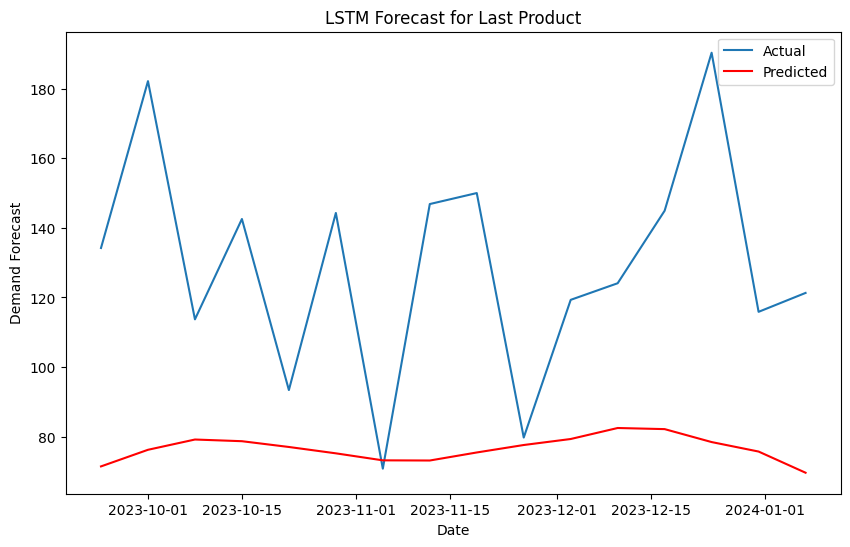

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('/kaggle/input/tryingagain/Retail_datasett.csv')

# Define the store ID and product ID range
store_id = 'S001'
product_ids = [f'P{str(i).zfill(4)}' for i in range(1, 21)]

# Prepare a DataFrame to store results
results = pd.DataFrame(columns=['Product ID', 'Date', 'Actual', 'Predicted'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Loop through each product ID
for product_id in product_ids:
    # Filter data for the specific store and product
    df_filtered = df[(df['Store ID'] == store_id) & (df['Product ID'] == product_id)]

    # Prepare the data
    df_filtered.loc[:, 'Date'] = pd.to_datetime(df_filtered['Date'])
    df_filtered.set_index('Date', inplace=True)

    # Select numeric columns for aggregation
    numeric_cols = ['Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing']
    df_numeric = df_filtered[numeric_cols]

    # Aggregate numeric data to weekly level
    df_weekly_numeric = df_numeric.resample('W').mean()

    # Extract seasonality information (e.g., month)
    df_weekly_numeric['Month'] = df_weekly_numeric.index.month

    # Convert seasonality to dummy variables
    df_weekly = pd.get_dummies(df_weekly_numeric, columns=['Month'])

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df_weekly)

    # Prepare the data for LSTM
    def create_dataset(data, time_step=1):
        X, Y = [], []
        for i in range(len(data) - time_step - 1):
            a = data[i:(i + time_step), :]
            X.append(a)
            Y.append(data[i + time_step, 0])  # Predicting 'Demand Forecast'
        return np.array(X), np.array(Y)

    time_step = 4
    X, Y = create_dataset(df_scaled, time_step)

    # Reshape input to be [samples, time steps, features]
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

    # Cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Build the LSTM model
        model = Sequential()
        model.add(Input(shape=(time_step, X.shape[2])))
        model.add(LSTM(50, return_sequences=True))
        model.add(Dropout(0.1))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dropout(0.1))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model with early stopping
        model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_split=0.2, verbose=2, callbacks=[early_stopping])

        # Make predictions
        test_predict = model.predict(X_test)

        # Inverse transform predictions
        test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], df_scaled.shape[1] - 1))), axis=1))[:, 0]
        Y_test_inv = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], df_scaled.shape[1] - 1))), axis=1))[:, 0]

        # Store the results
        test_dates = df_weekly.index[-len(test_predict):]
        product_results = pd.DataFrame({
            'Product ID': product_id,
            'Date': test_dates,
            'Actual': Y_test_inv,
            'Predicted': test_predict
        })
        results = pd.concat([results, product_results])

# Save the results to a CSV file
results.to_csv('/kaggle/working/forecast_results.csv', index=False)

# Plot the results for the last product
plt.figure(figsize=(10, 6))
plt.plot(product_results['Date'], product_results['Actual'], label='Actual')
plt.plot(product_results['Date'], product_results['Predicted'], label='Predicted', color='red')
plt.title('LSTM Forecast for Last Product')
plt.xlabel('Date')
plt.ylabel('Demand Forecast')
plt.legend()
plt.show()

# CHECKING LSTM FOR OVERALL STORE SALE

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 - 2s - 2s/step - loss: 0.4229
Epoch 2/100
1/1 - 0s - 22ms/step - loss: 0.3772
Epoch 3/100
1/1 - 0s - 21ms/step - loss: 0.3266
Epoch 4/100
1/1 - 0s - 21ms/step - loss: 0.2879
Epoch 5/100
1/1 - 0s - 21ms/step - loss: 0.2447
Epoch 6/100
1/1 - 0s - 21ms/step - loss: 0.2171
Epoch 7/100
1/1 - 0s - 20ms/step - loss: 0.1869
Epoch 8/100
1/1 - 0s - 21ms/step - loss: 0.1509
Epoch 9/100
1/1 - 0s - 22ms/step - loss: 0.1286
Epoch 10/100
1/1 - 0s - 22ms/step - loss: 0.1028
Epoch 11/100
1/1 - 0s - 22ms/step - loss: 0.0850
Epoch 12/100
1/1 - 0s - 22ms/step - loss: 0.0671
Epoch 13/100
1/1 - 0s - 22ms/step - loss: 0.0606
Epoch 14/100
1/1 - 0s - 21ms/step - loss: 0.0500
Epoch 15/100
1/1 - 0s - 21ms/step - loss: 0.0445
Epoch 16/100
1/1 - 0s - 24ms/step - loss: 0.0520
Epoch 17/100
1/1 - 0s - 22ms/step - loss: 0.0567
Epoch 18/100
1/1 - 0s - 21ms/step - loss: 0.0666
Epoch 19/100
1/1 - 0s - 21ms/step - loss: 0.0685
Epoch 20/100
1/1 - 0s - 21ms/step - loss: 0.0647
Epoch 21/100
1/1 - 0s - 21ms/step - loss: 0

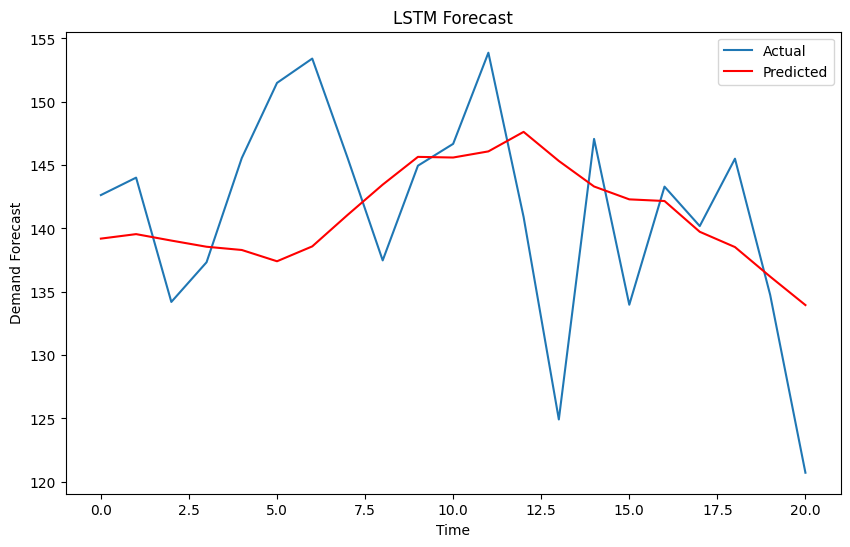

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset
df = pd.read_csv('/kaggle/input/tryingagain/Retail_datasett.csv')

# Filter data for a specific store
store_id = 'S001'
df_filtered = df[df['Store ID'] == store_id]

# Convert 'Date' to datetime and set as index
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])
df_filtered.set_index('Date', inplace=True)

# Select numeric columns for aggregation
numeric_cols = ['Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing']
df_numeric = df_filtered[numeric_cols]

# Aggregate numeric data to weekly level
df_weekly_numeric = df_numeric.resample('W').mean()

# Handle 'Weather Condition' separately by taking the mode
df_weekly_weather = df_filtered['Weather Condition'].resample('W').agg(lambda x: x.mode()[0])

# Extract seasonality information (e.g., month)
df_weekly_numeric['Month'] = df_weekly_numeric.index.month

# Merge the numeric, weather, and seasonality data
df_weekly = pd.concat([df_weekly_numeric, df_weekly_weather], axis=1)

# Convert categorical variables to dummy variables
df_weekly = pd.get_dummies(df_weekly, columns=['Weather Condition', 'Month'])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_weekly)

# Create sequences for LSTM
def create_sequences(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        Y.append(data[i + time_step, 0])  # Predicting 'Demand Forecast'
    return np.array(X), np.array(Y)

time_step = 4
X, Y = create_sequences(df_scaled, time_step)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=128, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], df_scaled.shape[1] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], df_scaled.shape[1] - 1))), axis=1))[:, 0]
Y_test_inv = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], df_scaled.shape[1] - 1))), axis=1))[:, 0]

# Evaluate the model
mse = mean_squared_error(Y_test_inv, test_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_inv, test_predict)

print(f'LSTM Model Evaluation:')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Y_test_inv, label='Actual')
plt.plot(test_predict, label='Predicted', color='red')
plt.title('LSTM Forecast')
plt.xlabel('Time')
plt.ylabel('Demand Forecast')
plt.legend()
plt.show()

# working on chatbot now

In [14]:
!pip install flask spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.2 MB/s eta 0:00:00:00:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [15]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 60.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.2/516.2 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.4/463.4 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [16]:
import gradio as gr
import spacy

# Load the spaCy model for NLP
nlp = spacy.load("en_core_web_sm")

# Example forecast data
forecast_data = {
    "2023-10-01": {"temperature": 20, "humidity": 50},
    "2023-10-02": {"temperature": 22, "humidity": 55},
    # Add more data as needed
}

def extract_date_and_metric(user_input):
    doc = nlp(user_input)
    date = None
    metric = None

    # Simple extraction logic
    for ent in doc.ents:
        if ent.label_ == "DATE":
            date = ent.text
    for token in doc:
        if token.text.lower() in ["temperature", "humidity"]:
            metric = token.text.lower()

    return date, metric

def chatbot(user_input):
    date, metric = extract_date_and_metric(user_input)

    if date and metric:
        forecast = forecast_data.get(date)
        if forecast and metric in forecast:
            response = f"The {metric} on {date} is {forecast[metric]}."
        else:
            response = "Sorry, I don't have the forecast data for that date or metric."
    else:
        response = "Please specify a date and a metric (temperature or humidity)."

    return response

# Create a Gradio interface
interface = gr.Interface(fn=chatbot, inputs="text", outputs="text", title="Forecast Chatbot")

# Launch the interface
interface.launch()

ImportError: cannot import name 'Sentinel' from 'typing_extensions' (/usr/local/lib/python3.11/dist-packages/typing_extensions.py)

In [17]:
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 9.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.1.7
    Uninstalling huggingface_hub-1.1.7:
      Successfully uninstalled huggingface_hub-1.1.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.


In [25]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import re

# Load the model and tokenizer
model_name = "microsoft/DialoGPT-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Load your forecast data from the CSV file
forecast_data = pd.read_csv('/kaggle/working/forecast_results.csv')

# Ensure the 'ds' column is in datetime format
forecast_data['ds'] = pd.to_datetime(forecast_data['ds'])

def get_forecast_context(product_id, date):
    # Convert the date string to a datetime object
    date = pd.to_datetime(date)
    
    # Find the forecast for the given product ID and date
    forecast_row = forecast_data[(forecast_data['Product ID'] == product_id) & (forecast_data['ds'] == date)]
    
    # Debugging: Print the filtered DataFrame
    print(f"Filtered DataFrame for {product_id} on {date}:")
    print(forecast_row)
    
    if not forecast_row.empty:
        # Extract the forecast values
        yhat = forecast_row['yhat'].values[0]
        yhat_lower = forecast_row['yhat_lower'].values[0]
        yhat_upper = forecast_row['yhat_upper'].values[0]
        confidence = forecast_row['confidence'].values[0] if 'confidence' in forecast_row else None
        confidence_str = f" with a confidence of {confidence:.4f}" if confidence is not None else ""
        return (f"The forecast for {product_id} on {date.strftime('%m/%d/%Y')} is {yhat} with a confidence interval "
                f"ranging from {yhat_lower} to {yhat_upper}{confidence_str}.")
    else:
        return "Sorry, I don't have the forecast data for that product and date."

def extract_date_and_product_id(prompt):
    # Simple regex to extract date and product ID
    date_match = re.search(r'\d{1,2}/\d{1,2}/\d{4}', prompt)
    product_id_match = re.search(r'P\d{4}', prompt)
    
    date = date_match.group(0) if date_match else None
    product_id = product_id_match.group(0) if product_id_match else None
    
    return product_id, date

def dialo_gpt_conversation(prompt):
    # Extract date and product ID from the prompt
    product_id, date = extract_date_and_product_id(prompt)
    
    if product_id and date:
        context = get_forecast_context(product_id, date)
    else:
        context = "Sorry, I couldn't extract the product ID or date from your query."
    
    # Debugging: Print extracted values and context
    print(f"Product ID: {product_id}, Date: {date}")
    print(f"Context: {context}")
    
    # Combine the context with the user prompt
    full_prompt = context + " " + prompt
    
    inputs = tokenizer.encode(full_prompt + tokenizer.eos_token, return_tensors="pt")
    outputs = model.generate(inputs, max_length=1000, pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(outputs[:, inputs.shape[-1]:][0], skip_special_tokens=True)

# Example usage
user_input = "What is the forecast for P0001 on 3/3/2024?"
response = dialo_gpt_conversation(user_input)
print(response)

OSError: Can't load the model for 'microsoft/DialoGPT-medium'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'microsoft/DialoGPT-medium' is the correct path to a directory containing a file named pytorch_model.bin, tf_model.h5, model.ckpt or flax_model.msgpack.

In [26]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import re
import gradio as gr

# Load the model and tokenizer
model_name = "microsoft/DialoGPT-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Load your forecast data from the CSV file
forecast_data = pd.read_csv('/kaggle/working/forecast_results.csv')

# Ensure the 'ds' column is in datetime format
forecast_data['ds'] = pd.to_datetime(forecast_data['ds'])

def get_forecast_context(product_id, date):
    # Convert the date string to a datetime object
    date = pd.to_datetime(date)
    
    # Find the forecast for the given product ID and date
    forecast_row = forecast_data[(forecast_data['Product ID'] == product_id) & (forecast_data['ds'] == date)]
    
    if not forecast_row.empty:
        # Extract the forecast values
        yhat = forecast_row['yhat'].values[0]
        yhat_lower = forecast_row['yhat_lower'].values[0]
        yhat_upper = forecast_row['yhat_upper'].values[0]
        confidence = forecast_row['confidence'].values[0] if 'confidence' in forecast_row else None
        confidence_str = f" with a confidence of {confidence:.4f}" if confidence is not None else ""
        return (f"The forecast for {product_id} on {date.strftime('%m/%d/%Y')} is {yhat} with a confidence interval "
                f"ranging from {yhat_lower} to {yhat_upper}{confidence_str}.")
    else:
        return "Sorry, I don't have the forecast data for that product and date."

def extract_date_and_product_id(prompt):
    # Simple regex to extract date and product ID
    date_match = re.search(r'\d{1,2}/\d{1,2}/\d{4}', prompt)
    product_id_match = re.search(r'P\d{4}', prompt)
    
    date = date_match.group(0) if date_match else None
    product_id = product_id_match.group(0) if product_id_match else None
    
    return product_id, date

def chatbot_with_context(prompt):
    # Extract date and product ID from the prompt
    product_id, date = extract_date_and_product_id(prompt)
    
    if product_id and date:
        context = get_forecast_context(product_id, date)
    else:
        context = "Sorry, I couldn't extract the product ID or date from your query."
    
    # Combine the context with the user prompt
    full_prompt = context + " " + prompt
    
    inputs = tokenizer.encode(full_prompt + tokenizer.eos_token, return_tensors="pt")
    outputs = model.generate(inputs, max_length=1000, pad_token_id=tokenizer.eos_token_id)
    response = tokenizer.decode(outputs[:, inputs.shape[-1]:][0], skip_special_tokens=True)
    
    # Return the context and response
    return f"Context: {context}\n"

# Create a Gradio interface
interface = gr.Interface(
    fn=chatbot_with_context,
    inputs="text",
    outputs="text",
    title="Forecast Chatbot",
    description="A chatbot that provides forecast data and generates responses."
)

# Launch the interface
interface.launch()

ImportError: cannot import name 'Sentinel' from 'typing_extensions' (/usr/local/lib/python3.11/dist-packages/typing_extensions.py)

# final working chatbot

In [28]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import re
import gradio as gr

# Load the model and tokenizer
model_name = "microsoft/DialoGPT-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Load your forecast data from the CSV file
forecast_data = pd.read_csv('/kaggle/working/forecast_results.csv')

# Ensure the 'ds' column is in datetime format
forecast_data['ds'] = pd.to_datetime(forecast_data['ds'])

def get_forecast_context(product_id, date):
    # Convert the date string to a datetime object
    try:
        date = pd.to_datetime(date)
    except Exception:
        return "Sorry, I couldn't understand the date format."
    
    # Find the forecast for the given product ID and date
    forecast_row = forecast_data[
        (forecast_data['Product ID'] == product_id) & (forecast_data['ds'] == date)
    ]
    
    if not forecast_row.empty:
        # Extract the forecast values
        yhat = forecast_row['yhat'].values[0]
        yhat_lower = forecast_row['yhat_lower'].values[0]
        yhat_upper = forecast_row['yhat_upper'].values[0]
        confidence = forecast_row['confidence'].values[0]
        return (
            f"Forecast for {product_id} on {date.strftime('%Y-%m-%d')}: "
            f"{yhat:.2f} (range: {yhat_lower:.2f} - {yhat_upper:.2f}, "
            f"confidence: {confidence:.4f})"
        )
    else:
        return "Sorry, I don't have the forecast data for that product and date."

def extract_date_and_product_id(prompt):
    # Regex to extract date (MM/DD/YYYY or YYYY-MM-DD) and product ID (P followed by 4 digits)
    date_match = re.search(r'(\d{1,2}/\d{1,2}/\d{4})|(\d{4}-\d{2}-\d{2})', prompt)
    product_id_match = re.search(r'P\d{4}', prompt)
    
    date = date_match.group(0) if date_match else None
    product_id = product_id_match.group(0) if product_id_match else None
    
    return product_id, date

def chatbot_with_context(prompt):
    # Extract date and product ID from the prompt
    product_id, date = extract_date_and_product_id(prompt)
    
    if product_id and date:
        # If both are found, return the forecast directly
        return get_forecast_context(product_id, date)
    else:
        # Otherwise, use DialoGPT for general conversation
        inputs = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors="pt")
        outputs = model.generate(inputs, max_length=1000, pad_token_id=tokenizer.eos_token_id)
        response = tokenizer.decode(outputs[:, inputs.shape[-1]:][0], skip_special_tokens=True)
        return response

# Create a Gradio interface
interface = gr.Interface(
    fn=chatbot_with_context,
    inputs="text",
    outputs="text",
    title="Forecast Chatbot",
    description="A chatbot that provides forecast data and can also chat."
)

# Launch the interface
interface.launch()

ImportError: cannot import name 'Sentinel' from 'typing_extensions' (/usr/local/lib/python3.11/dist-packages/typing_extensions.py)

In [22]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import re
import gradio as gr

# Load the model and tokenizer
model_name = "microsoft/DialoGPT-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Load your forecast data from the CSV file
forecast_data = pd.read_csv('/kaggle/working/forecast_results.csv')
forecast_data['ds'] = pd.to_datetime(forecast_data['ds'])

def get_data_response(product_id, date, intent):
    try:
        date = pd.to_datetime(date)
    except Exception:
        return "Sorry, I couldn't understand the date format."
    
    row = forecast_data[
        (forecast_data['Product ID'] == product_id) & (forecast_data['ds'] == date)
    ]
    
    if row.empty:
        return "Sorry, I don't have the data for that product and date."
    
    if intent == "forecast":
        yhat = row['yhat'].values[0]
        yhat_lower = row['yhat_lower'].values[0]
        yhat_upper = row['yhat_upper'].values[0]
        confidence = row['confidence'].values[0]
        return (
            f"Forecast for {product_id} on {date.strftime('%Y-%m-%d')}: "
            f"{yhat:.2f} (range: {yhat_lower:.2f} - {yhat_upper:.2f}, "
            f"confidence: {confidence:.4f})"
        )
    elif intent == "record":
        if 'actual' in row.columns:
            # actual = row['actual'].values[0]
            return f"Record for {product_id} on {date.strftime('%Y-%m-%d')}: {actual:.2f}"
        else:
            return "Sorry, I don't have the actual record for that product and date."
    else:
        return "Sorry, I couldn't determine if you wanted the forecast or the record."

def extract_date_and_product_id(prompt):
    date_match = re.search(r'(\d{1,2}/\d{1,2}/\d{4})|(\d{4}-\d{2}-\d{2})', prompt)
    product_id_match = re.search(r'P\d{4}', prompt)
    date = date_match.group(0) if date_match else None
    product_id = product_id_match.group(0) if product_id_match else None
    return product_id, date

def detect_intent(prompt):
    prompt = prompt.lower()
    if "forecast" in prompt:
        return "forecast"
    elif "record" in prompt or "actual" in prompt or "real" in prompt:
        return "record"
    else:
        return None

def chatbot_with_context(prompt):
    product_id, date = extract_date_and_product_id(prompt)
    intent = detect_intent(prompt)
    if product_id and date and intent:
        return get_data_response(product_id, date, intent)
    else:
        # Use DialoGPT for general conversation
        inputs = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors="pt")
        outputs = model.generate(inputs, max_length=1000, pad_token_id=tokenizer.eos_token_id)
        response = tokenizer.decode(outputs[:, inputs.shape[-1]:][0], skip_special_tokens=True)
        return response

# Gradio interface
interface = gr.Interface(
    fn=chatbot_with_context,
    inputs="text",
    outputs="text",
    title="Forecast & Record Chatbot",
    description="Ask for forecast or record data for a product and date."
)

interface.launch()

ImportError: cannot import name 'Sentinel' from 'typing_extensions' (/usr/local/lib/python3.11/dist-packages/typing_extensions.py)

In [24]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import re
import gradio as gr
import calendar

# Load the model and tokenizer
model_name = "microsoft/DialoGPT-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Load your forecast data from the CSV file
forecast_data = pd.read_csv('/kaggle/working/forecast_results.csv')
forecast_data['ds'] = pd.to_datetime(forecast_data['ds'])

def extract_date_and_product_id(prompt):
    # Regex to extract date (MM/DD/YYYY or YYYY-MM-DD) and product ID (P followed by 4 digits)
    date_match = re.search(r'(\d{1,2}/\d{1,2}/\d{4})|(\d{4}-\d{2}-\d{2})', prompt)
    product_id_match = re.search(r'P\d{4}', prompt)
    date = date_match.group(0) if date_match else None
    product_id = product_id_match.group(0) if product_id_match else None
    return product_id, date

def extract_product_month_year(prompt):
    # Product ID
    product_id_match = re.search(r'P\d{4}', prompt)
    product_id = product_id_match.group(0) if product_id_match else None

    # Month and year (e.g., March 2024 or 03/2024)
    month_match = re.search(r'(January|February|March|April|May|June|July|August|September|October|November|December)\s+(\d{4})', prompt, re.IGNORECASE)
    if month_match:
        month = list(calendar.month_name).index(month_match.group(1).capitalize())
        year = int(month_match.group(2))
    else:
        # Try MM/YYYY
        month_match = re.search(r'(\d{1,2})/(\d{4})', prompt)
        if month_match:
            month = int(month_match.group(1))
            year = int(month_match.group(2))
        else:
            month = None
            year = None

    return product_id, month, year

def detect_intent(prompt):
    prompt = prompt.lower()
    if "forecast" in prompt:
        return "forecast"
    elif "record" in prompt or "actual" in prompt or "real" in prompt:
        return "record"
    elif "increase" in prompt or "decrease" in prompt or "trend" in prompt or "change" in prompt:
        return "trend"
    else:
        return None

def get_data_response(product_id, date, intent):
    try:
        date = pd.to_datetime(date)
    except Exception:
        return "Sorry, I couldn't understand the date format."
    
    row = forecast_data[
        (forecast_data['Product ID'] == product_id) & (forecast_data['ds'] == date)
    ]
    
    if row.empty:
        return "Sorry, I don't have the data for that product and date."
    
    if intent == "forecast":
        yhat = row['yhat'].values[0]
        yhat_lower = row['yhat_lower'].values[0]
        yhat_upper = row['yhat_upper'].values[0]
        confidence = row['confidence'].values[0]
        return (
            f"Forecast for {product_id} on {date.strftime('%Y-%m-%d')}: "
            f"{yhat:.2f} (range: {yhat_lower:.2f} - {yhat_upper:.2f}, "
            f"confidence: {confidence:.4f})"
        )
    elif intent == "record":
        if 'actual' in row.columns:
            actual = row['actual'].values[0]
            return f"Record for {product_id} on {date.strftime('%Y-%m-%d')}: {actual:.2f}"
        else:
            return "Sorry, I don't have the actual record for that product and date."
    else:
        return "Sorry, I couldn't determine if you wanted the forecast or the record."

def compare_monthly_forecast(product_id, month, year):
    if not all([product_id, month, year]):
        return "Sorry, I couldn't extract the product, month, or year from your question."

    # Current month
    mask_current = (
        (forecast_data['Product ID'] == product_id) &
        (forecast_data['ds'].dt.month == month) &
        (forecast_data['ds'].dt.year == year)
    )
    current_sum = forecast_data.loc[mask_current, 'yhat'].sum()

    # Previous month
    prev_month = month - 1 if month > 1 else 12
    prev_year = year if month > 1 else year - 1
    mask_prev = (
        (forecast_data['Product ID'] == product_id) &
        (forecast_data['ds'].dt.month == prev_month) &
        (forecast_data['ds'].dt.year == prev_year)
    )
    prev_sum = forecast_data.loc[mask_prev, 'yhat'].sum()

    if current_sum == 0 or prev_sum == 0:
        return "Sorry, I don't have enough forecast data for those months."

    diff = current_sum - prev_sum
    percent = (diff / prev_sum) * 100

    if diff > 0:
        trend = "increase"
    elif diff < 0:
        trend = "decrease"
    else:
        trend = "stay about the same"

    return (
        f"Forecasted sales for {product_id} in {calendar.month_name[month]} {year} are expected to {trend} "
        f"by {abs(percent):.1f}% compared to the previous month "
        f"({calendar.month_name[prev_month]} {prev_year}).\n"
        f"Previous month total: {prev_sum:.2f}, Current month total: {current_sum:.2f}."
    )

def chatbot_with_context(prompt):
    intent = detect_intent(prompt)
    if intent == "trend":
        product_id, month, year = extract_product_month_year(prompt)
        return compare_monthly_forecast(product_id, month, year)
    elif intent in ["forecast", "record"]:
        product_id, date = extract_date_and_product_id(prompt)
        if product_id and date:
            return get_data_response(product_id, date, intent)
        else:
            return "Sorry, I couldn't extract the product ID or date from your query."
    else:
        # Use DialoGPT for general conversation
        inputs = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors="pt")
        outputs = model.generate(inputs, max_length=1000, pad_token_id=tokenizer.eos_token_id)
        response = tokenizer.decode(outputs[:, inputs.shape[-1]:][0], skip_special_tokens=True)
        return response

# Gradio interface
interface = gr.Interface(
    fn=chatbot_with_context,
    inputs="text",
    outputs="text",
    title="Forecast & Record Chatbot",
    description="Ask for forecast, record, or sales trend for a product and date/month."
)

interface.launch()

ImportError: cannot import name 'Sentinel' from 'typing_extensions' (/usr/local/lib/python3.11/dist-packages/typing_extensions.py)